# GOLEM Example: Electron Energy Confinement Time $\tau_E$ Calculation

Strategic flowchart (credit from GOLEM website)
<br/>
<img src="flowchart_energy_confinement_time.jpg" width="75%">

## Python Intro

In [1]:
### NOTE: Please use  python 3 version of language/kernel
## First we import the necessary modules (libraries)
# activates the inline plotting backend in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import cumtrapz
from scipy import constants
from urllib.request  import urlopen #python 3.0 
from urllib.request  import urlretrieve #python 3.0 
import urllib
import os

# setup the local directory in which to save the data
try:
        os.stat('shots/')
except:
        os.mkdir('shots/') 

In [2]:
# Next we define some fundamental constants and parameters
RogowskiCalibration = 5.3e6  # Calibration for Rogowski coil
UloopCalibration = 5.5 # Calibration for U loop measurement
V_p = 0.057 #m^3 Plasma volume
k_B = constants.k # Boltzmann constant
eV = constants.e # 1 eV equivalent to J
baseURL = "http://golem.fjfi.cvut.cz/utils/data/"

In [3]:
VacuumShotNo = 22475
PlasmaShotNo = 22471

In [4]:
#The following function will download the text file of the given data in the given shot and read it into an array and return it.
ds = np.DataSource()

def open_data(shot_no, data_id):
    shotDIR = 'shots/' + str(shot_no)
    dataADR = str(shot_no) + '/' + str(data_id) + '.npz'
    dataURL = baseURL + dataADR
    try:
        os.stat(shotDIR)
    except:
        os.mkdir(shotDIR)  
    try:
        data = np.load('shots/' + dataADR)
    except:    
        urlretrieve (dataURL,'shots/' + dataADR)
        data = np.load('shots/' + dataADR)
    return data 

## Chamber resistance $R_{ch}$ calculation from vacuum shot
### Plot raw data from NIstandard DAS

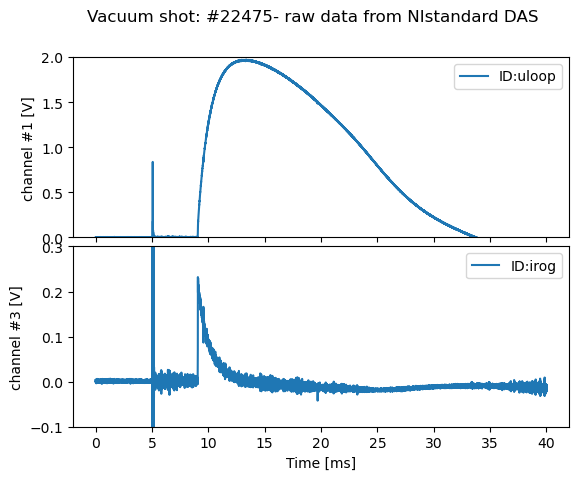

In [5]:
# First let's get the data from the DAS in the columns specified by the given identifiers.
IDuloop = open_data(VacuumShotNo,'uloop')
IDirog = open_data(VacuumShotNo,'irog')
time =  np.linspace(IDuloop['t_start'],IDuloop['t_end'], len(IDuloop['data']))

# Let's show raw data:
f,ax = plt.subplots(2,sharex=True)
f.suptitle('Vacuum shot: #'+str(VacuumShotNo)+ '- raw data from NIstandard DAS')

f.subplots_adjust(hspace=0.05)
ax[0].set_ylim(0,2)
ax[0].set_ylabel('channel #1 [V]')
ax[0].plot(time*1e3, IDuloop['data'],label='ID:uloop')
ax[1].set_ylim(-.1,0.3)
ax[1].set_ylabel('channel #3 [V]')
ax[1].plot(time*1e3, IDirog['data'],label='ID:irog')
ax[1].set_xlabel('Time [ms]')
[a.legend(loc='best') for a in ax]
plt.show()

### Get real physical quantities from raw data
Physical quantities can be obtained by multiplying the raw data by appropriate calibration constants. In the case of the current, the derivative is measured, so the signal has to be numerically integrated.

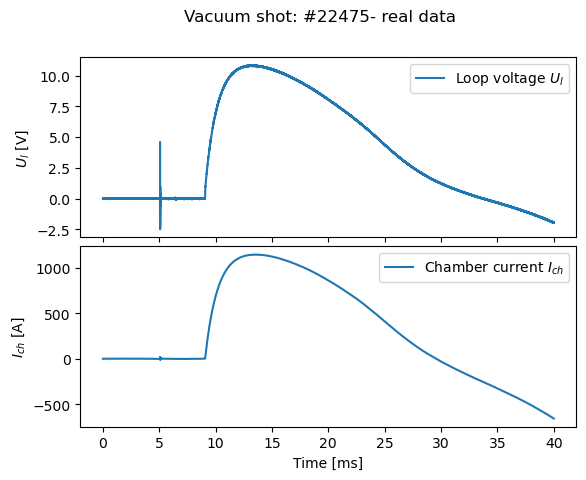

In [6]:
# Uloop from IDuloop needs only multiplication
U_l = IDuloop['data']*UloopCalibration
# Chamber current I_ch needs offset correction, integration and calibration
i_offset = time.searchsorted(.004)
offset = np.mean(IDirog['data'][:i_offset]) # Up to 4 ms no signal, good zero specification
I_ch = cumtrapz(IDirog['data']-offset, time,initial=0)  # offset correction and integration
I_ch *= RogowskiCalibration # calibration

# And let's plot it
f,ax = plt.subplots(2,sharex=True)
f.subplots_adjust(hspace=0.05)
f.suptitle('Vacuum shot: #'+str(VacuumShotNo)+ '- real data')

ax[0].set_ylabel('$U_l$ [V]')
ax[0].plot(time*1e3,U_l,label='Loop voltage $U_l$')
ax[1].set_ylabel('$I_{ch}$ [A]')
ax[1].plot(time*1e3,I_ch,label='Chamber current $I_{ch}$')
ax[1].set_xlabel('Time [ms]')
[a.legend(loc='best') for a in ax]
plt.show()

### Final chamber resistance specification
The chanber resistnace should be calculated in the time span where the physical quantities are reasonably stationary.

In [7]:
t_start = time.searchsorted(0.014) 
t_end = time.searchsorted(0.015) 
# R_ch calculation via Ohm's law:
R_ch = (U_l[t_start:t_end]/I_ch[t_start:t_end]) # in Ohms
# final value
R_ch, R_err = np.mean(R_ch), np.std(R_ch)

print("Chamber resistance =  (%.2f +/- %.2f) mOhm"%(R_ch*1e3, R_err*1e3))

Chamber resistance =  (9.38 +/- 0.02) mOhm


## Energy confinement time  $\tau_{E}$ calculation from plasma shot
### Plot raw data from NIstandard DAS and interferometer

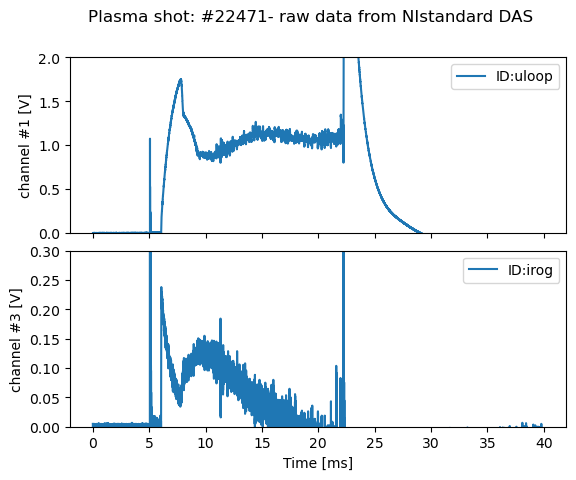

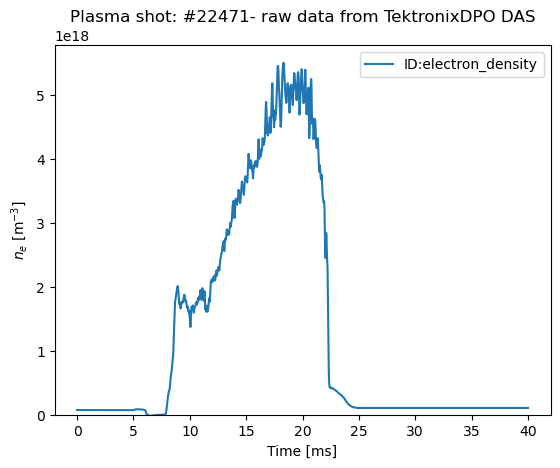

In [8]:
# Get data
IDuloop = open_data(PlasmaShotNo,'uloop')
IDirog = open_data(PlasmaShotNo,'irog')
#time =  np.linspace(IDuloop['t_start'],IDuloop['t_end'], len(IDuloop['data']))

IDelectron_density = open_data(PlasmaShotNo,'electron_density')
#interpolate the density on the same time axis as the rest of the quantities
n_e = IDelectron_density['data']
time_ne =  np.linspace(IDelectron_density['t_start'],IDelectron_density['t_end'], len(n_e))
n_e = np.interp(time, time_ne, n_e)

# Let's show raw data from NIstandard:
f,ax = plt.subplots(2,sharex=True)
f.subplots_adjust(hspace=0.1)
f.suptitle('Plasma shot: #'+str(PlasmaShotNo)+ '- raw data from NIstandard DAS')

ax[0].set_ylim(0,2)
ax[0].set_ylabel('channel #1 [V]')
ax[0].plot(time*1e3, IDuloop['data'],label='ID:uloop')
ax[1].set_ylim(0,0.3)
ax[1].set_ylabel('channel #3 [V]')
ax[1].plot(time*1e3, IDirog['data'],label='ID:irog')
ax[1].set_xlabel('Time [ms]')
[a.legend(loc='best') for a in ax]
plt.show()

# Let's show raw data from interferometer diagnostics :
f,ax = plt.subplots()
ax.set_title('Plasma shot: #'+str(PlasmaShotNo)+ '- raw data from TektronixDPO DAS')

ax.set_xlabel('Time [ms]')
ax.set_ylabel('$n_e\ \mathrm{[m^{-3}]}$')
ax.plot(time*1e3, n_e,label='ID:electron_density')
ax.legend() 
ax.set_ylim(0,None)
plt.show()

## Get real physical data 

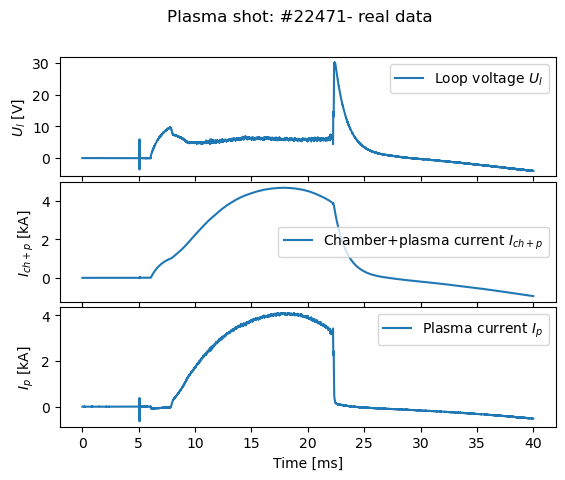

In [9]:
# Uloop from IDuloop needs only multiplication
U_l = IDuloop['data']*UloopCalibration
# Chamber current I_ch needs offset correction, integration and calibration
offset = np.mean(IDirog['data'][:i_offset]) # Up to 4 ms no signal, good zero specification
I_chANDp = cumtrapz(IDirog['data']-offset, time, initial=0)  # offset correction and integration
I_chANDp *= RogowskiCalibration # calibration
I_p=I_chANDp-U_l/R_ch # getting real plasma current from Ohm's law

# And let's plot it
f,ax = plt.subplots(3,sharex=True )
f.subplots_adjust(hspace=0.05)
f.suptitle(r'Plasma shot: #'+str(PlasmaShotNo)+ '- real data')

ax[0].set_ylabel('$U_l$ [V]')
ax[0].plot(time*1e3, U_l,label='Loop voltage $U_l$')
ax[1].set_ylabel('$I_{ch+p}$ [kA]')
ax[1].plot(time*1e3,I_chANDp/1e3,label='Chamber+plasma current $I_{ch+p}$')
ax[2].set_ylabel('$I_{p}$ [kA]')
ax[2].plot(time*1e3,I_p/1e3,label='Plasma current $I_{p}$')
ax[2].set_xlabel('Time [ms]')
[a.legend(loc='best') for a in ax]
plt.show()

## Data correlation ..

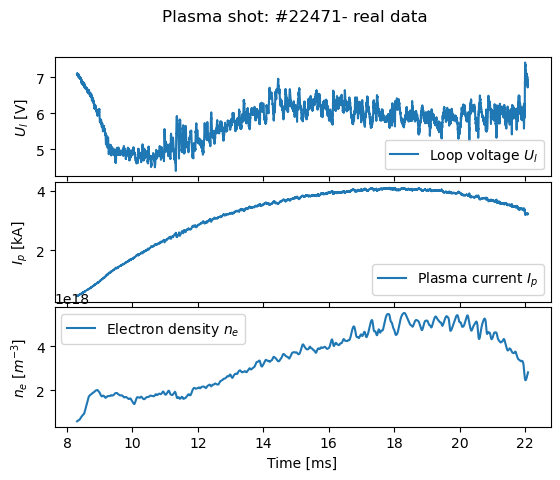

In [10]:
#select only a signal with the plasma 
i_start,i_end = time.searchsorted((IDuloop['plasma_start']+5e-4,IDuloop['plasma_end']-5e-4))

n_e = n_e[i_start:i_end]
I_p = I_p[i_start:i_end]
U_l = U_l[i_start:i_end]
time = time[i_start:i_end]


# And let's plot it
f,ax = plt.subplots(3,sharex=True)
f.subplots_adjust(hspace=0.05)
f.suptitle('Plasma shot: #'+str(PlasmaShotNo)+ '- real data')

ax[0].set_ylabel('$U_l$ [V]')
ax[0].plot(time*1e3, U_l,label='Loop voltage $U_l$')
ax[1].set_ylabel('$I_{p}$ [kA]')
ax[1].plot(time*1e3,I_p/1e3,label='Plasma current $I_{p}$')
ax[2].set_ylabel('$n_{e}$ [$m^{-3}$]')
ax[2].plot(time*1e3,n_e,label='Electron density $n_{e}$')
ax[-1].set_xlabel('Time [ms]')
[a.legend(loc='best') for a in ax]
plt.show()

## Final calculations

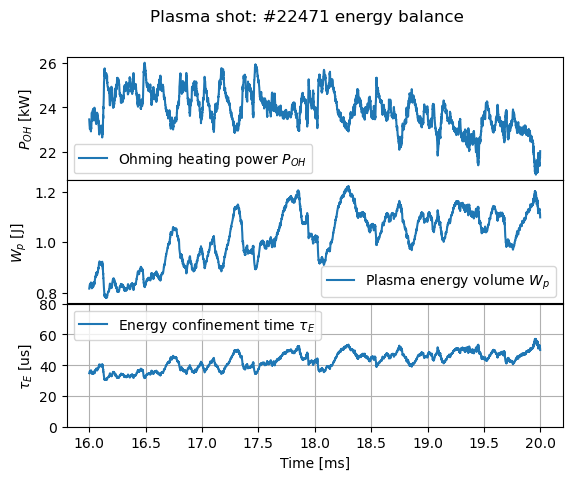

Energy confinement time =  (43 +/- 6) us


In [11]:
R_p = np.maximum(0,U_l/I_p) # plasma resistivity adopted to avoid power(xx,-2./3) problems @ T_e calculation
P_OH = U_l*I_p  # Plasma heating power
T_e = 0.9*R_p**(-2./3) # Electron temperature (the GOLEM specific case)
W_p = V_p*n_e*eV*T_e/3 # Energy content in the plasma
# Let's make final calculations in the stationary phase to avoid complex derivation calculations of plasma energy balance
imin,imax = time.searchsorted((0.016, 0.020))
P_OH = P_OH[imin:imax]
W_p = W_p[imin:imax]
time = time[imin:imax]
tau = W_p/P_OH 
#Plot
f,ax = plt.subplots(3, sharex=True)
f.suptitle('Plasma shot: #'+str(PlasmaShotNo)+ ' energy balance')

f.subplots_adjust(hspace=0.001)
ax[0].set_ylabel('$P_{OH}$ [kW]')
ax[0].plot(time*1e3, P_OH/1000,label='Ohming heating power $P_{OH}$')
ax[1].set_ylabel('$W_p$ [J]')
ax[1].plot(time*1e3,W_p,label='Plasma energy volume $W_p$')
ax[2].set_ylabel(r'$\tau_E$ [us]')
ax[2].plot(time*1e3,tau*1e6,label=r'Energy confinement time $\tau_E$')
ax[2].set_ylim(0,80)
ax[2].grid('on')
[a.legend(loc='best') for a in ax]
ax[-1].set_xlabel('Time [ms]')
plt.show()

# Final calculation
tau, tau_err = np.mean(tau), np.std(tau)
print("Energy confinement time =  (%.0f +/- %.0f) us"%(tau*1e6,tau_err*1e6))

Resources:

* [(.html) version](http://golem.fjfi.cvut.cz/wikiraw/Education/ExperimentMenu/ElectronEnergyConfinementTime/Code/Jupyter/script.html)
